# Master notebook

## Import packages

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Set figure parameters
plt.rcParams['figure.figsize'] = [10, 7.5]

## Input data

C:\Users\User\AppData\Local\Temp\ipykernel_5756\614998373.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(filepath, parse_dates=['Date'])


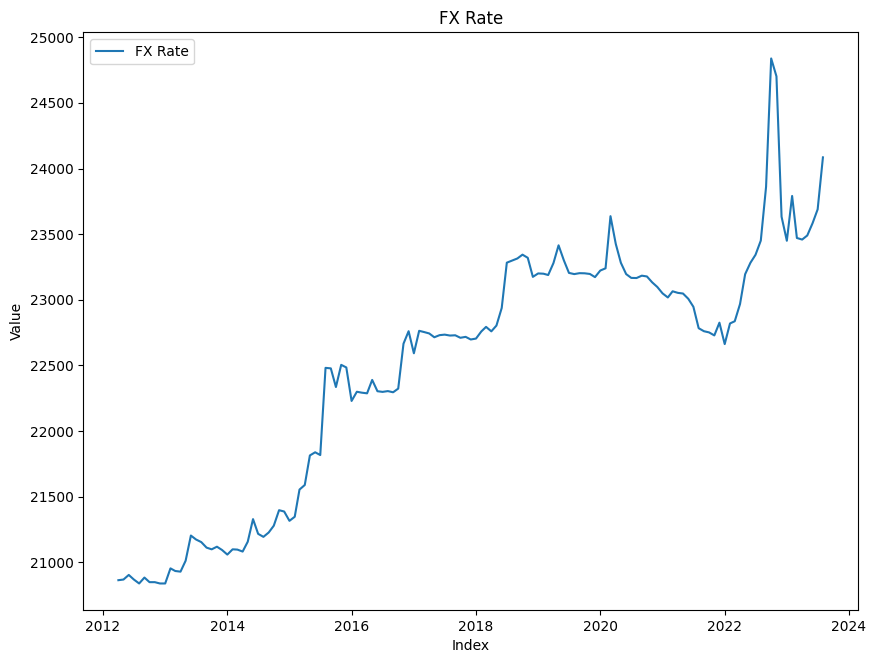

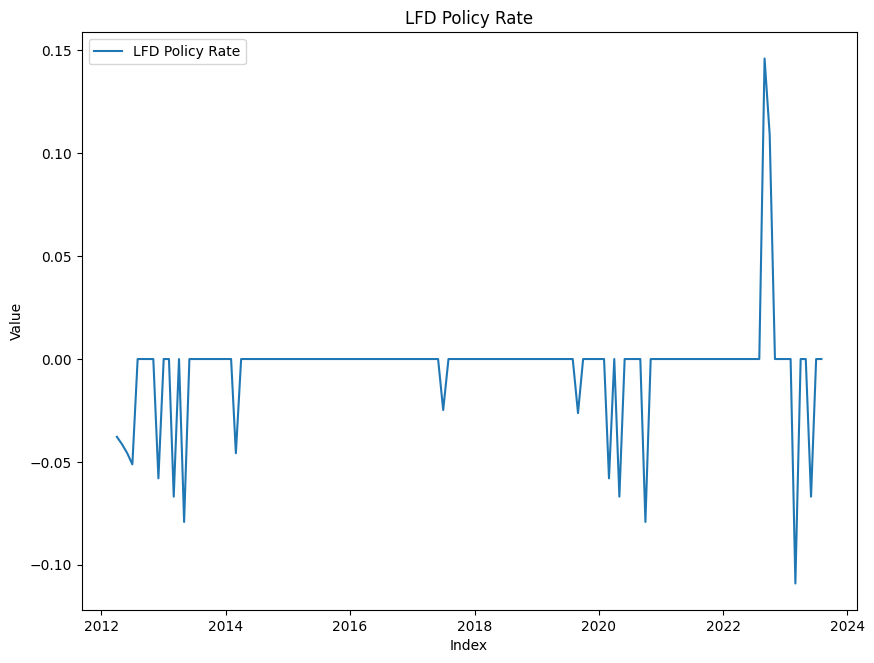

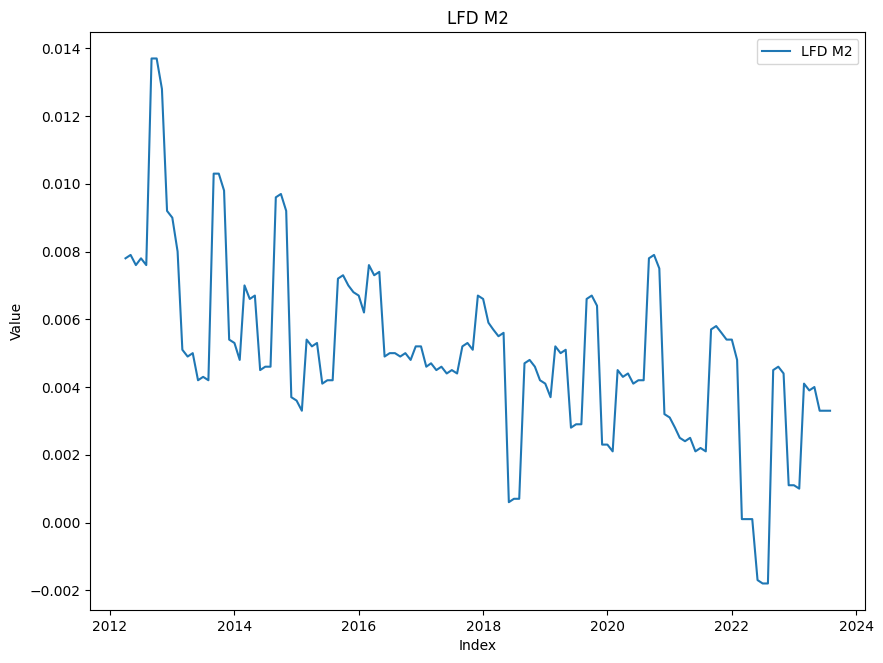

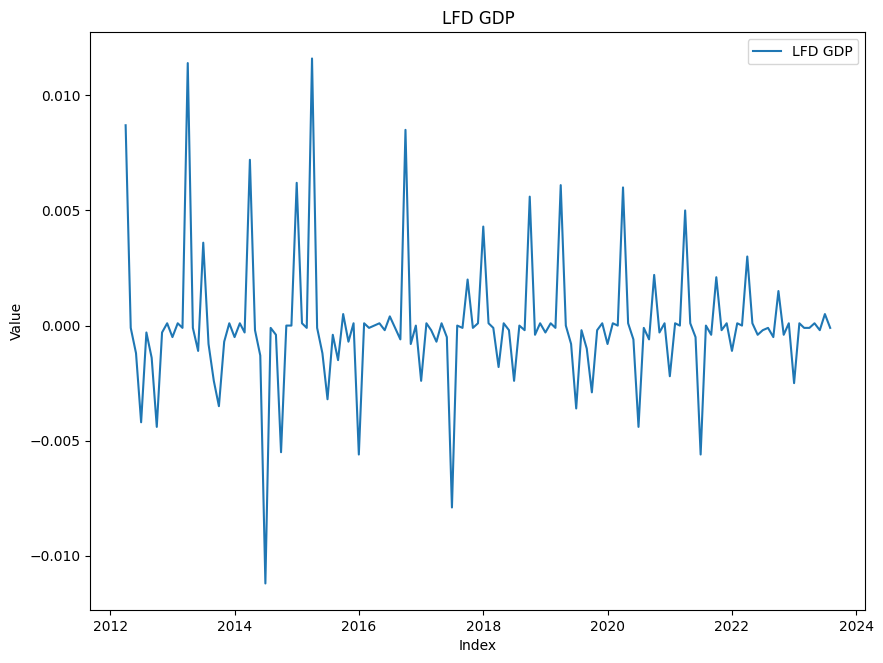

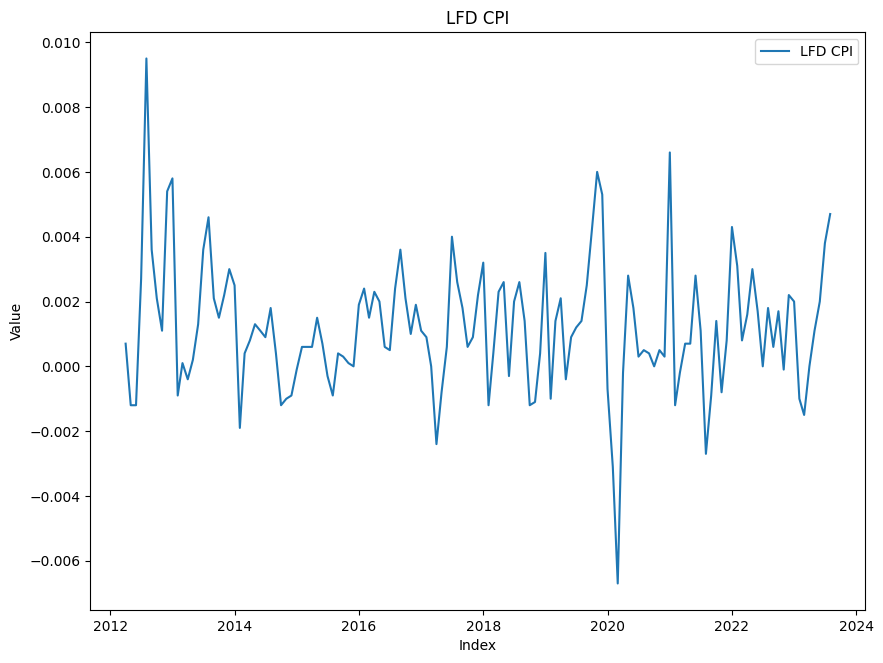

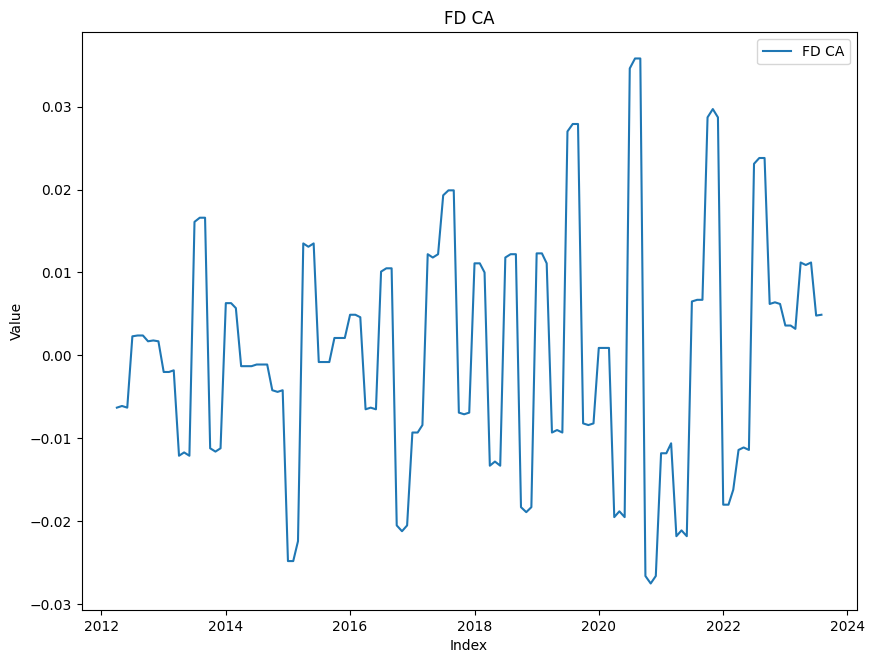

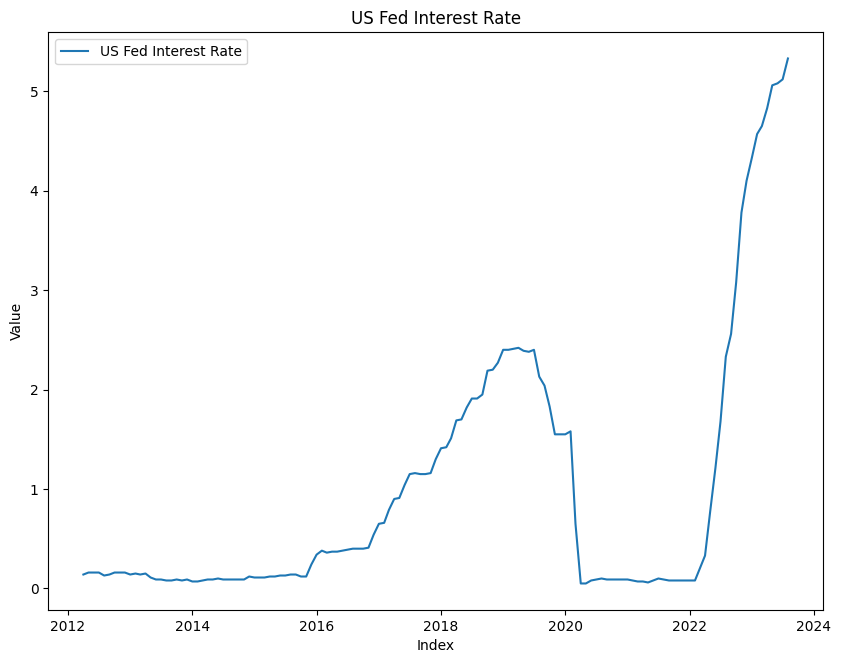

In [166]:
# Filepath to the CSV file
filepath = r"C:\Users\User\Desktop\Clone git\FinalisedData.csv"

# Read the CSV file, specifying the date format
data = pd.read_csv(filepath, parse_dates=['Date'])

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Retaining only wanted data
data = data[['FX Rate','LFD Policy Rate','LFD M2','LFD GDP','LFD CPI','FD CA','US Fed Interest Rate']]

# Drop rows with NaN values
data.dropna(inplace=True)

# Format datetime
data.index = pd.to_datetime(data.index, format='%b-%y')

# Plot each column separately
for column in data.columns:
    plt.figure()  # Create a new figure for each plot
    plt.plot(data.index, data[column], label=column)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(column)
    plt.legend()
    plt.show()

## 

## Models

### ARIMA

In [167]:
# Import pacakages
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

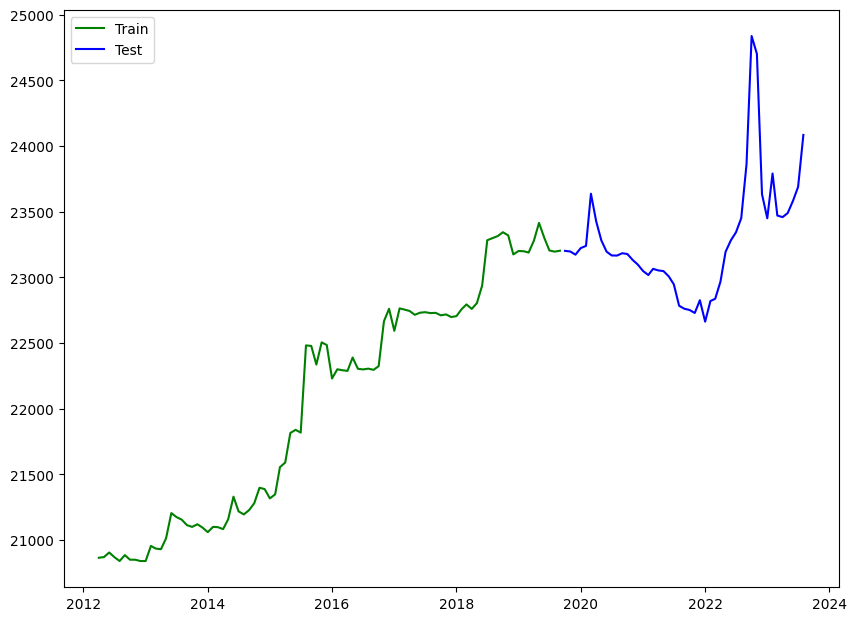

In [168]:
# Seperate into train and test data
to_row_arima = int(len(data)*0.66)

arima_train = list(data[0:to_row_arima]['FX Rate'])
arima_test = list(data[to_row_arima:]['FX Rate'])

# Plot
plt.plot(data[0:to_row_arima]['FX Rate'], 'green', label='Train')
plt.plot(data[to_row_arima:]['FX Rate'],'blue',label='Test')
plt.legend()
plt.show()

In [169]:
# Finding ARIMA parameters automatically
model= auto_arima(data[0:to_row]['FX Rate'].diff().dropna(), seasonal=False, stepwise= False, d= None, suppress_warnings=True)
print(model.order)

(2, 0, 2)


In [170]:
model_predictions = []
n_test_obser = len(arima_test)

p = 2
d = 0
q = 2

for i in range(n_test_obser):
    model = ARIMA(arima_train, order=(p,d,q))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = list(output)
    model_predictions.append(yhat)
    actual_test_value = arima_test[i]
    arima_train.append(actual_test_value)
    
# model_fit.summary()

arima_pred = model_predictions

C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


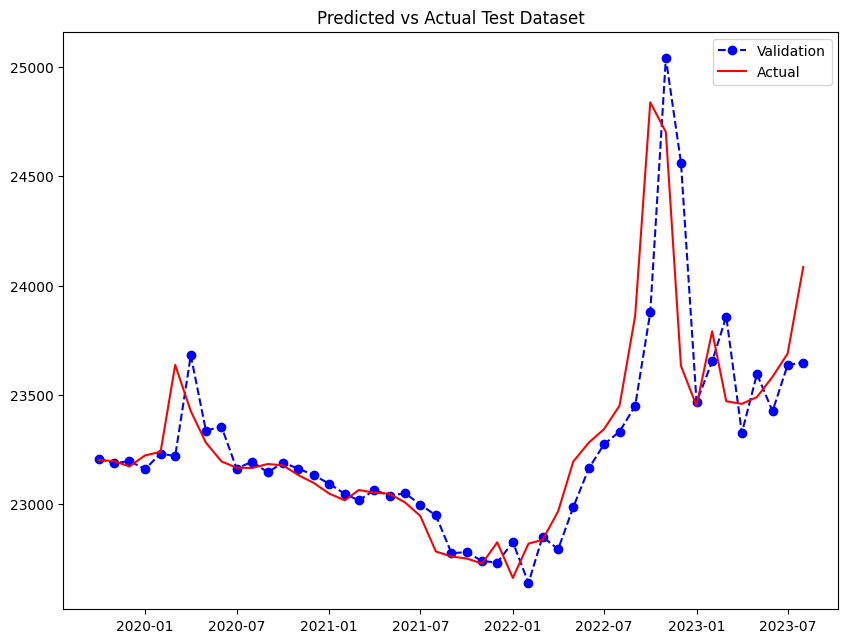

In [171]:
date_range = data[to_row_arima:].index
plt.plot(date_range, model_predictions, color = 'blue', marker = 'o', linestyle = 'dashed', label = 'Validation')
plt.plot(date_range, arima_test, color = 'red', label = 'Actual')
plt.legend()
plt.title('Predicted vs Actual Test Dataset')
plt.show()

In [172]:
# Forecast forward
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)

C:\Users\User\AppData\Local\Temp\ipykernel_5756\1684231579.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comb_df = pd.concat([data[to_row_arima:], future_dates_df])


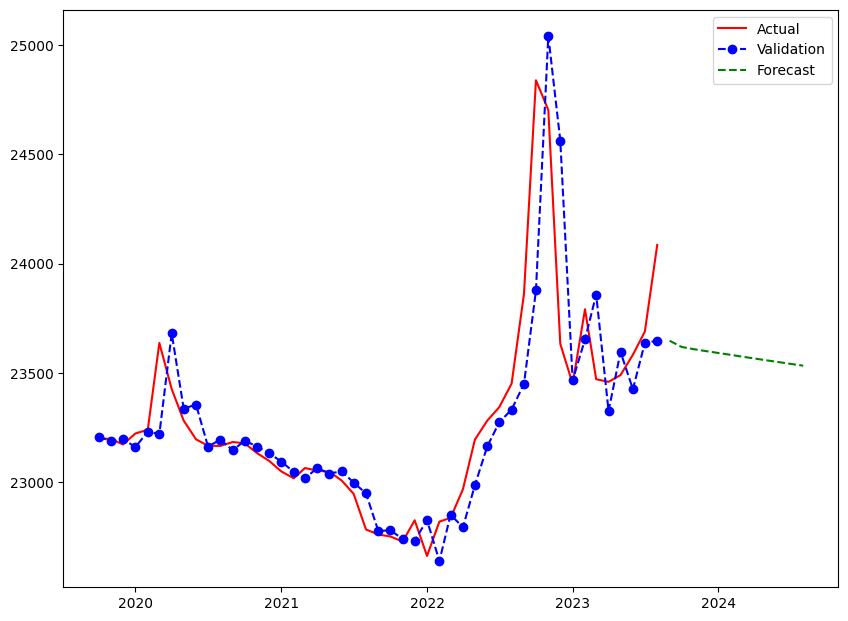

In [173]:
from pandas.tseries.offsets import DateOffset

future_dates = [data.index[-1] + DateOffset(months = x) for x in range (0,forecast_steps+1)]
future_dates_df = pd.DataFrame(index = future_dates[1:], columns = data.columns)
comb_df = pd.concat([data[to_row_arima:], future_dates_df])

plt.plot(data[to_row_arima:].index, data[to_row_arima:]['FX Rate'], color = 'red', label = 'Actual')
plt.plot(data[to_row_arima:].index, model_predictions, color = 'blue', marker = 'o', linestyle = 'dashed', label = 'Validation')
plt.plot(future_dates_df.index, forecast, color = 'green', linestyle = 'dashed', label = 'Forecast')
plt.legend()

arima_pred = forecast

### Multivariate OLS

### XG Boost

### LSTM

In [174]:
# Input packages

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from imblearn.under_sampling import RandomUnderSampler

In [175]:
# prepare data
dataset = data.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# separate into train and test data
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size 
lstm_train, lstm_test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back= 2):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 2
trainX, trainY = create_dataset(lstm_train, look_back)
testX, testY = create_dataset(lstm_test, look_back)

# reshape input to be [samples, time steps, features]
n = 7 # number of columns
trainX = np.reshape(trainX, (trainX.shape[0], look_back, n))
testX = np.reshape(testX, (testX.shape[0], look_back, n))

In [176]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(64, input_shape=(look_back, n)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=300, batch_size=16, verbose=1)

# Save the trained model
model.save('trained_lstm_model.h5')

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = np.squeeze(trainPredict)
testPredict = np.squeeze(testPredict)

Epoch 1/300


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1783
Epoch 2/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0967 
Epoch 3/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0446 
Epoch 4/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0328 
Epoch 5/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0344 
Epoch 6/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0312 
Epoch 7/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0234 
Epoch 8/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 
Epoch 9/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184 
Epoch 10/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0158 
Epoch 11/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0128 
Epoch 12/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 
Epoch 13/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 
Epoch 14/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 
Epoch 15/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 
Epoch 16/300
6/6 ━━━━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [177]:
# Transform data
def inverse_transform(arr):
    extended = np.zeros((len(arr), n))
    extended[:, 0] = arr
    return scaler.inverse_transform(extended)[:, 0]


trainPredict = inverse_transform(trainPredict)
testPredict = inverse_transform(testPredict)
trainY = inverse_transform(trainY)
testY = inverse_transform(testY)

In [178]:
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)

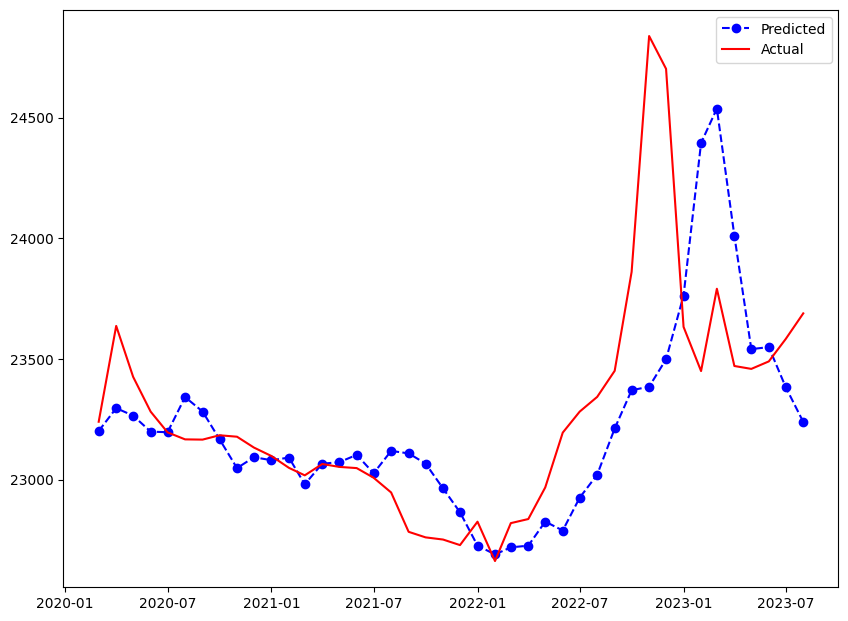

In [188]:
# shift predictions up by one
testPredict = np.delete(testPredict, -1)
testY = np.delete(testY, 0)

to_row_lstm = len(data) - len(testY)
date_range = data[to_row_lstm:].index
plt.plot(date_range, testPredict, color = 'blue', marker = 'o', linestyle = 'dashed', label = 'Predicted')
plt.plot(date_range, testY, color = 'red', label = 'Actual')
plt.legend()
plt.show()

In [189]:
from tensorflow.keras.models import load_model

def generate_forecasts(model_path, test_data, forecast_steps):
    """
    Generate forecasts beyond the test data using a trained LSTM model.
    
    Args:
    - model_path: Path to the trained LSTM model file.
    - test_data: Test data used for model evaluation.
    - forecast_steps: Number of future time steps to forecast.
    
    Returns:
    - forecasts: Array containing the forecasted values.
    """
    # Load the trained LSTM model
    model = load_model(model_path)
    
    # Prepare the test data for forecasting
    current_data = np.copy(test_data)
    
    # Generate forecasts
    forecasts = []
    for _ in range(forecast_steps):
        # Predict the next time step
        next_step_prediction = model.predict(current_data.reshape(1, *current_data.shape))
        
        # Append the prediction to the forecasts
        forecasts.append(next_step_prediction[0, 0])
        
        # Update current data by removing the oldest time step and appending the latest prediction
        current_data = np.roll(current_data, -1)
        current_data[-1] = next_step_prediction
    
    return np.array(forecasts)

# Example usage:
# Replace 'trained_lstm_model.h5' with the path to your trained LSTM model file
# Replace 'test_data' with your actual test data
# Replace 'forecast_steps' with the number of future time steps to forecast
# forecasts = generate_forecasts('trained_lstm_model.h5', test_data, forecast_steps)


In [190]:
test_data = testX[-1]
forecast_steps = 12

In [191]:
forecasts = generate_forecasts('trained_lstm_model.h5', test_data, forecast_steps)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [192]:
forecasts = np.squeeze(forecasts)

# Transform data
def inverse_transform(arr):
    extended = np.zeros((len(arr), n))
    extended[:, 0] = arr
    return scaler.inverse_transform(extended)[:, 0]

forecasts = inverse_transform(forecasts)

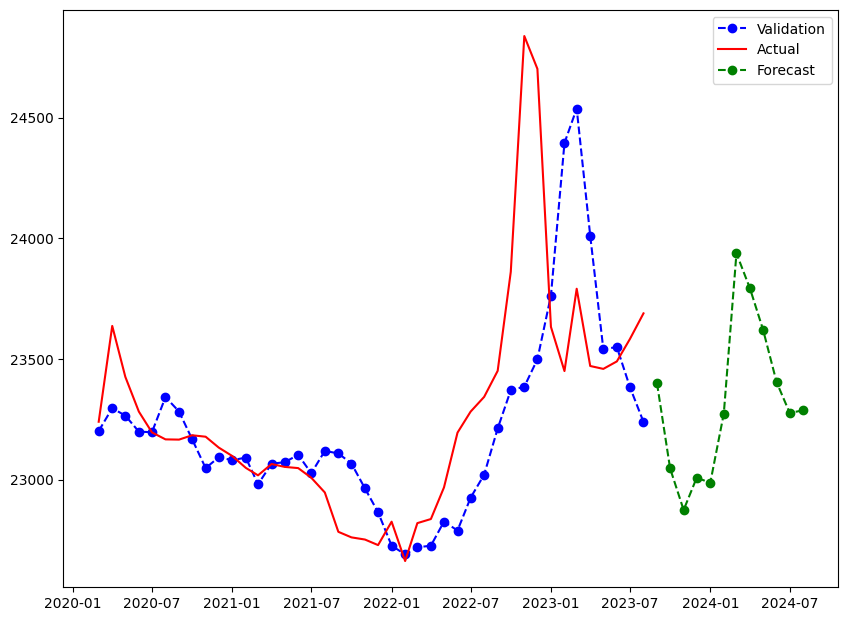

In [200]:
from pandas.tseries.offsets import DateOffset
future_dates = [data.index[-1] + DateOffset(months = x) for x in range (0,forecast_steps+1)]
future_dates_df = pd.DataFrame(index = future_dates[1:], columns = data.columns)

plt.plot(date_range, testPredict, color = 'blue', marker = 'o', linestyle = 'dashed', label = 'Validation')
plt.plot(date_range, testY, color = 'red', label = 'Actual')
plt.plot(future_dates_df.index, forecasts, color = 'green', marker = 'o', linestyle = 'dashed', label = 'Forecast')
plt.legend()

lstm_pred = forecasts

## Evaluation metrics

In [201]:
# MSE


# RMSE


# RMPSE

# Forecast for next year

In [202]:
# Create dataframe
forecast_df = pd.DataFrame()

# Add values to a new column
forecast_df['ARIMA f'] = arima_pred
forecast_df['LSTM f'] = lstm_pred


,ARIMA f,LSTM f
0,23646.982669,23399.359727
1,23618.765402,23046.651412
2,23608.393292,22874.474404
3,23599.624944,23008.528280
4,23591.054754,22986.884025
5,23582.560664,23273.733069
6,23574.131671,23937.785220
7,23565.766380,23792.070403
8,23557.464232,23621.009589
9,23549.224744,23403.745388


## Multivariate OLS

## XG Boost

# Average of all 4 models

## Validation data

## Forecast data

### Evaluation metrics (between models)